# IMPORTATION DES LIBRAIRIES

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Chargement du dataset

In [4]:
df = pd.read_csv('dataset/dataset_cleaned/df_machine_failure.csv')
print(f"Dimensions du dataset original: {df.shape}")
print(f"Distribution des classes:\n{df['failure_in_14d'].value_counts(normalize=True)}")

Dimensions du dataset original: (6684643, 39)
Distribution des classes:
failure_in_14d
0    0.963333
1    0.036667
Name: proportion, dtype: float64


# Préparation du tableau

- Echantillonage

In [5]:
classe_0 = df[df['failure_in_14d'] == 0]
classe_1 = df[df['failure_in_14d'] == 1]

In [6]:
sample_size_classe_1 = len(classe_1)
sample_size_classe_0 = sample_size_classe_1

In [7]:
classe_0_sampled = classe_0.sample(n=sample_size_classe_0, random_state=42)
df1 = pd.concat([classe_0_sampled, classe_1])

In [8]:
print(f"\nDimensions après échantillonnage: {df1.shape}")
print(f"Distribution des classes après échantillonnage:\n{df1['failure_in_14d'].value_counts(normalize=True)}")


Dimensions après échantillonnage: (490212, 39)
Distribution des classes après échantillonnage:
failure_in_14d
0    0.5
1    0.5
Name: proportion, dtype: float64


- Features Temporelles granulaires

In [9]:
df1['datetime']=pd.to_datetime(df1['datetime'])

In [10]:
df1['day_of_year'] = df1['datetime'].dt.dayofyear.astype(int)
df1['week_of_year'] = df1['datetime'].dt.isocalendar().week.astype(int)
df1['month'] = df1['datetime'].dt.month.astype(int)
df1['is_month_start'] = df1['datetime'].dt.is_month_start.astype(int)
df1['is_month_end'] = df1['datetime'].dt.is_month_end.astype(int)

- Saisonnalité annuelle

In [11]:
df1['sin_day'] = np.sin(2 * np.pi * df1['day_of_year'] / 365)
df1['cos_day'] = np.cos(2 * np.pi * df1['day_of_year'] / 365)

- Conserver le datetime comme index

In [12]:
df1.set_index('datetime', inplace=True)

- Suppression des colonnes nons pertinentes

In [13]:
df1.drop(columns=['machineID'], inplace=True)
df1

,volt,rotate,pressure,vibration,age,error_count,maint_count,is_model1,is_model2,is_model3,...,had_error_last_3h,had_maint_last_3h,failure_in_14d,day_of_year,week_of_year,month,is_month_start,is_month_end,sin_day,cos_day
datetime,,,,,,,,,,,,,,,,,,,,,
2015-12-29 02:00:00,148.952525,541.824187,95.298891,47.071383,14,0.0,0.0,False,True,False,...,0,0,0,363,53,12,0,0,-3.442161e-02,0.999407
2015-07-11 02:00:00,158.988256,425.656041,88.485861,49.171647,20,0.0,0.0,True,False,False,...,0,0,0,192,28,7,0,0,-1.628070e-01,-0.986658
2015-09-03 04:00:00,162.290735,327.559714,100.734289,42.814621,10,0.0,0.0,False,False,False,...,0,0,0,246,36,9,0,0,-8.880573e-01,-0.459733
2015-10-19 19:00:00,172.843640,361.874074,91.294569,41.459171,4,0.0,0.0,False,False,False,...,0,0,0,292,43,10,0,0,-9.510565e-01,0.309017
2015-04-21 21:00:00,177.139700,366.468582,109.236020,41.551920,12,0.0,0.0,False,True,False,...,0,0,0,111,17,4,0,0,9.427611e-01,-0.333469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 04:00:00,196.312559,519.495652,108.726917,41.701246,18,0.0,0.0,False,True,False,...,0,0,1,365,53,12,0,1,6.432491e-16,1.000000
2015-12-31 05:00:00,210.361451,538.381700,136.617842,54.532230,14,0.0,0.0,False,False,True,...,0,0,1,365,53,12,0,1,6.432491e-16,1.000000
2015-12-31 05:00:00,181.998731,449.718546,89.244777,41.117843,20,0.0,0.0,False,False,True,...,0,0,1,365,53,12,0,1,6.432491e-16,1.000000


- Conversion des booléens en entiers

In [14]:
df1 = df1.astype({col: 'int' for col in df1.select_dtypes(include='bool').columns})

- Normalisation des données

In [15]:
numeric_cols = df1.select_dtypes(include=['int64', 'float64']).columns

In [16]:
# On garde uniquement les colonnes ayant plus que 2 valeurs distinctes (on exclu les bools et 'machineID')
norm_cols = [col for col in numeric_cols if df1[col].nunique() > 2]

In [17]:
rbscaler=RobustScaler()
df_n=rbscaler.fit_transform(df1[norm_cols])
df_n

array([[-1.04433212,  1.34356785, -0.37184184, ...,  1.        ,
        -0.0487864 ,  0.69915255],
       [-0.56582785, -0.29181122, -0.85003646, ...,  0.16666667,
        -0.13976794, -0.69624213],
       [-0.40836544, -1.67278084,  0.00965922, ...,  0.5       ,
        -0.65372345, -0.32602842],
       ...,
       [ 0.53131301,  0.04693324, -0.79676947, ...,  1.        ,
        -0.0243932 ,  0.6995689 ],
       [ 0.62927571,  1.93298258, -0.00207422, ...,  1.        ,
        -0.0243932 ,  0.6995689 ],
       [ 1.9671974 ,  0.11210306,  0.74492696, ...,  1.        ,
        -0.0243932 ,  0.6995689 ]])

In [18]:
df_n = pd.DataFrame(df_n, columns=norm_cols, index=df1.index)

In [19]:
df_norm=df1.copy()
df_norm[norm_cols] = df_n
df_norm

,volt,rotate,pressure,vibration,age,error_count,maint_count,is_model1,is_model2,is_model3,...,had_error_last_3h,had_maint_last_3h,failure_in_14d,day_of_year,week_of_year,month,is_month_start,is_month_end,sin_day,cos_day
datetime,,,,,,,,,,,,,,,,,,,,,
2015-12-29 02:00:00,-1.044332,1.343568,-0.371842,0.943354,0.00,0.0,0.0,0,1,0,...,0,0,0,1.010989,1.038462,1.000000,0,0,-0.048786,0.699153
2015-07-11 02:00:00,-0.565828,-0.291811,-0.850036,1.237332,0.75,0.0,0.0,1,0,0,...,0,0,0,0.071429,0.076923,0.166667,0,0,-0.139768,-0.696242
2015-09-03 04:00:00,-0.408365,-1.672781,0.009659,0.347526,-0.50,0.0,0.0,0,0,0,...,0,0,0,0.368132,0.384615,0.500000,0,0,-0.653723,-0.326028
2015-10-19 19:00:00,0.094798,-1.189714,-0.652898,0.157801,-1.25,0.0,0.0,0,0,0,...,0,0,0,0.620879,0.653846,0.666667,0,0,-0.698368,0.214089
2015-04-21 21:00:00,0.299634,-1.125034,0.606381,0.170783,-0.25,0.0,0.0,0,1,0,...,0,0,0,-0.373626,-0.346154,-0.333333,0,0,0.643703,-0.237316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 04:00:00,1.213797,1.029234,0.570648,0.191685,0.50,0.0,0.0,0,1,0,...,0,0,1,1.021978,1.038462,1.000000,0,1,-0.024393,0.699569
2015-12-31 05:00:00,1.883649,1.295106,2.528263,1.987664,0.00,0.0,0.0,0,0,1,...,0,0,1,1.021978,1.038462,1.000000,0,1,-0.024393,0.699569
2015-12-31 05:00:00,0.531313,0.046933,-0.796769,0.110025,0.75,0.0,0.0,0,0,1,...,0,0,1,1.021978,1.038462,1.000000,0,1,-0.024393,0.699569


- Gestion des valeurs manquantes

In [20]:
df_norm.isnull().sum().sum()

np.int64(600)

In [21]:
df_norm.dropna(inplace=True)

In [22]:
df_norm.isnull().sum().sum()

np.int64(0)

# MODELISATION

- Séparation en variables indépendantes et variable cible

In [23]:
X=df_norm.drop(columns=['failure_in_14d'])
y=df_norm['failure_in_14d']

- Séparation en train et test

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Choix du model

In [26]:
print("\n--- LIGHTGBM ---")
# Définition des hyperparamètres à optimiser
param_grid_lgbm = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400],
    'num_leaves': [31, 50, 100, 150],
    'max_depth': [5, 7, 9, -1],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'boosting_type': ['gbdt', 'dart'],
    'importance_type': ['split', 'gain'],
    'verbosity':[-1]
}

# Utiliser cette configuration pour le RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits=5)

# Recherche des meilleurs hyperparamètres
lgbm_base = LGBMClassifier(class_weight='balanced', random_state=42)
random_search_lgbm = RandomizedSearchCV(
    lgbm_base,
    param_grid_lgbm,
    n_iter=10,
    cv=tscv,
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Optimisation des hyperparamètres en cours...")
random_search_lgbm.fit(X_train, y_train)
print(f"Meilleurs paramètres: {random_search_lgbm.best_params_}")

# Utilisation du meilleur modèle
best_lgbm = random_search_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

# Évaluation
print("\nRapport de classification:")
print(classification_report(y_test, y_pred_lgbm))

print("\nMatrice de confusion:")
print(confusion_matrix(y_test, y_pred_lgbm))


--- LIGHTGBM ---
Optimisation des hyperparamètres en cours...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Meilleurs paramètres: {'verbosity': -1, 'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 150, 'n_estimators': 400, 'min_child_samples': 50, 'max_depth': -1, 'learning_rate': 0.05, 'importance_type': 'gain', 'colsample_bytree': 0.9, 'boosting_type': 'dart'}

Rapport de classification:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     49210
           1       0.75      0.98      0.85     48818

    accuracy                           0.82     98028
   macro avg       0.86      0.82      0.82     98028
weighted avg       0.86      0.82      0.82     98028


Matrice de confusion:
[[32959 16251]
 [ 1110 47708]]


### Evaluation

In [29]:
# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba_lgbm)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.8643


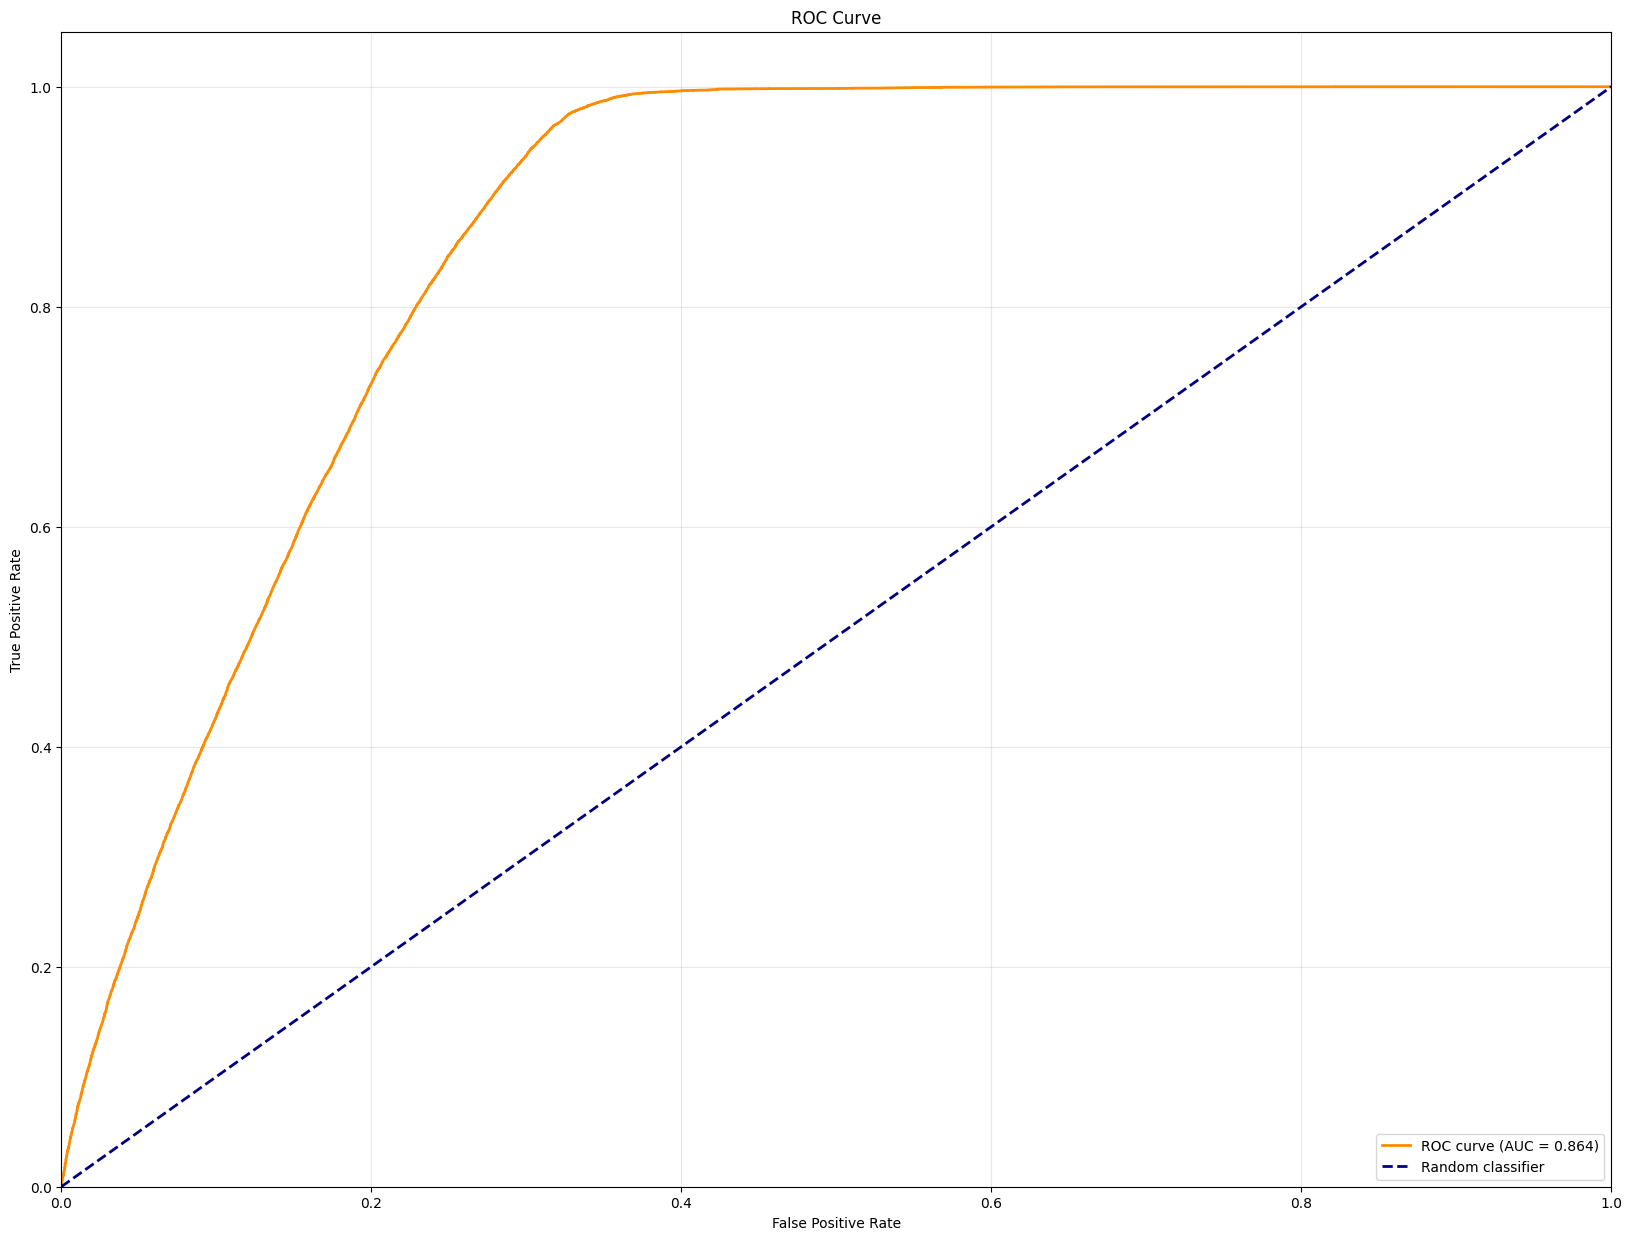

In [37]:
# ROC Curve
fig = plt.figure(figsize=(20, 15))
fpr, tpr, _ = roc_curve(y_test, y_proba_lgbm)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

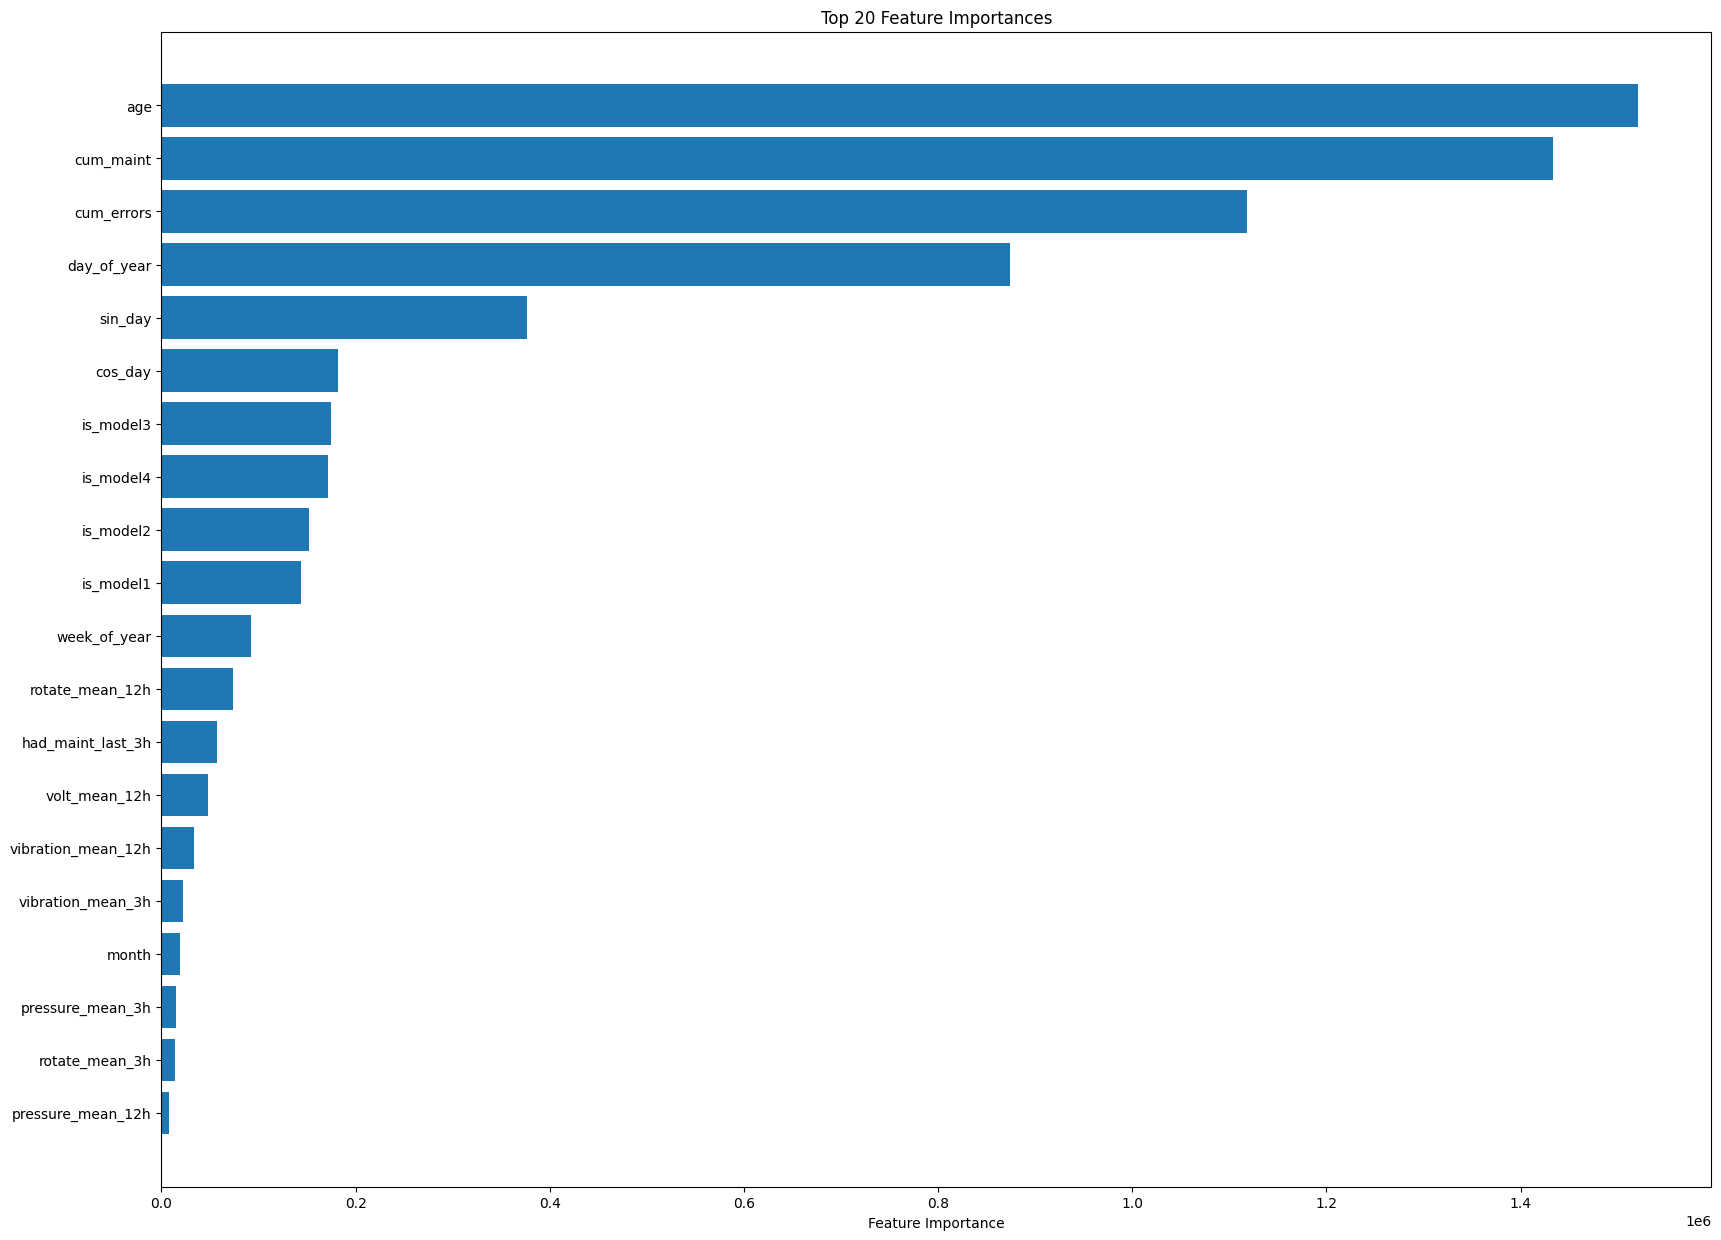

In [39]:
# Feature Importance (Top 20)
fig = plt.figure(figsize=(20, 15))
feature_importance = best_lgbm.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(len(feature_importance))]
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(20)

plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()